In [1]:
import tensorflow as tf
import tensorflow.keras
import pandas as pd
import numpy as np
import os
import glob
from tensorflow.keras import layers, models, preprocessing
from tensorflow.keras.optimizers import RMSprop, Adam
import keras_tuner as kt

2024-03-09 20:07:09.933345: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-03-09 20:07:10.700506: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
PALM_DATA_DIR = '../data-PALM'

def get_image_paths_and_labels(subset_dir):
    base_dir = PALM_DATA_DIR  
    image_dir = os.path.join(base_dir, subset_dir, 'Images')
    image_paths = glob.glob(os.path.join(image_dir, '*.jpg'))

    labels_file = os.path.join(base_dir, subset_dir, 'Classification Labels.xlsx')
    labels_df = pd.read_excel(labels_file)

    # Check if 'imgName' column exists in the labels dataframe
    if 'imgName' not in labels_df.columns:
        raise KeyError(f"Column 'imgName' not found in the labels dataframe. Existing columns are: {labels_df.columns}")

    # Logic to extract labels corresponding to each image path based on filenames
    labels = []
    for image_path in image_paths:
        image_filename = os.path.basename(image_path)
        label = labels_df.loc[labels_df['imgName'] == image_filename, 'Label'].values[0]
        labels.append(label)
    return image_paths, labels

train_image_paths, train_labels = get_image_paths_and_labels('Training/')
val_image_paths, val_labels = get_image_paths_and_labels('Validation/')
test_image_paths, test_labels = get_image_paths_and_labels('Testing/')


In [3]:
# Combine image paths from all subsets
all_image_paths = train_image_paths + val_image_paths + test_image_paths
all_labels = train_labels + val_labels + test_labels

In [4]:
from sklearn.model_selection import train_test_split

train_image_paths, val_image_paths, train_labels, val_labels = train_test_split(
    all_image_paths, all_labels, test_size=0.2, random_state=42, stratify=all_labels)

In [5]:
def preprocess_image(image_path, label):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [224, 224])
    image = tf.keras.applications.resnet_v2.preprocess_input(image)
    return image, label

In [6]:
import tensorflow as tf
import random

def create_dataset(image_paths, labels, batch_size, is_training=True):
    # Convert lists to TensorFlow tensors
    image_paths = tf.constant(image_paths)
    labels = tf.constant(labels)
    
    # Create a TensorFlow dataset from the tensors
    dataset = tf.data.Dataset.from_tensor_slices((image_paths, labels))
    
    # Map the preprocessing function with parallel processing
    dataset = dataset.map(lambda x, y: preprocess_image(x, y), num_parallel_calls=tf.data.AUTOTUNE)
    
    if is_training:
        # Shuffle the dataset using the buffer size and enable reshuffling each iteration
        dataset = dataset.shuffle(buffer_size=BUFFER_SIZE, reshuffle_each_iteration=True)
    
    # Batch the dataset and prefetch to improve performance
    dataset = dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)
    
    return dataset

# Assuming BUFFER_SIZE, BATCH_SIZE, and mirrored_strategy are defined
BUFFER_SIZE = 200
BATCH_SIZE_PER_REPLICA = 20
mirrored_strategy = tf.distribute.MirroredStrategy()
BATCH_SIZE = BATCH_SIZE_PER_REPLICA * mirrored_strategy.num_replicas_in_sync

# Use the oversampled dataset for training
train_ds = create_dataset(list(train_image_paths), list(train_labels), BATCH_SIZE, is_training=True)
val_ds = create_dataset(list(val_image_paths), list(val_labels), BATCH_SIZE, is_training=False)  # Validation dataset doesn't necessarily need oversampling


INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1', '/job:localhost/replica:0/task:0/device:GPU:2', '/job:localhost/replica:0/task:0/device:GPU:3', '/job:localhost/replica:0/task:0/device:GPU:4')


2024-03-09 20:07:12.434682: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-03-09 20:07:12.435231: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-03-09 20:07:12.435834: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

2024-03-09 20:07:16.090977: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


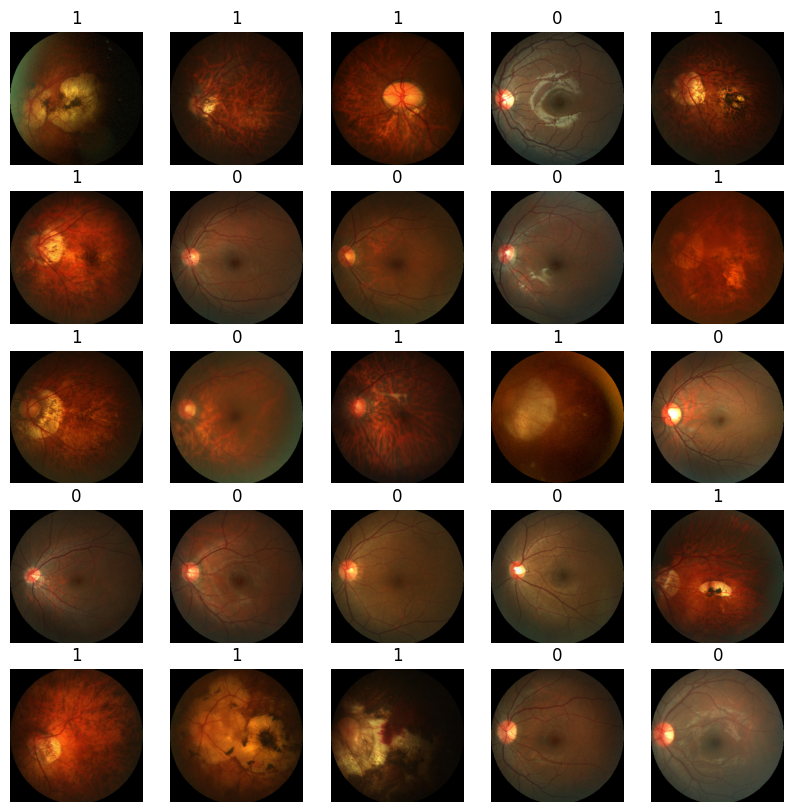

In [7]:
import matplotlib.pyplot as plt

def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10,10))
    for n in range(min(len(image_batch), 25)):
        ax = plt.subplot(5, 5, n+1)
        plt.imshow(image_batch[n] / 2 + 0.5)  # Rescale back to [0,1] if preprocessing included normalization
        plt.title(label_batch[n].numpy())
        plt.axis('off')

# Taking one batch from the training dataset
for image_batch, label_batch in train_ds.take(1):
    show_batch(image_batch.numpy(), label_batch)

# Note: This visualization step assumes that your preprocessing function normalizes the images in a way that can be reversed for visualization.


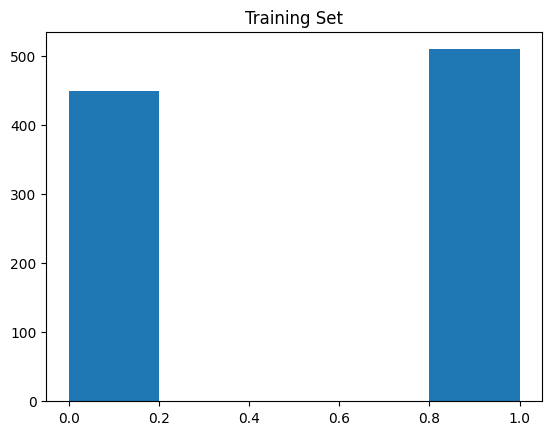

In [8]:
# show the distribution of the labels in the training set, the validation set, and the test set
def show_label_distribution(labels, title):
    plt.title(title)
    plt.hist(labels, bins=5)
    plt.show()
show_label_distribution(train_labels, 'Training Set')

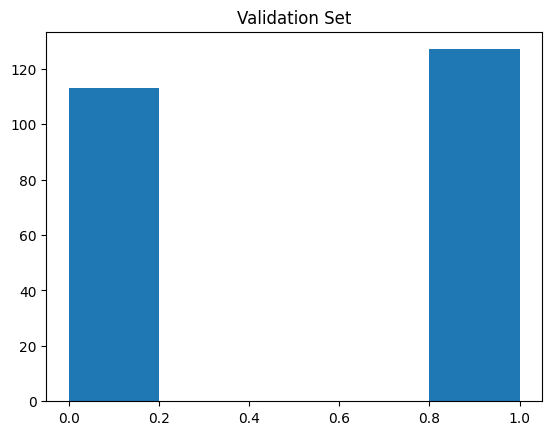

In [9]:
show_label_distribution(val_labels, 'Validation Set')

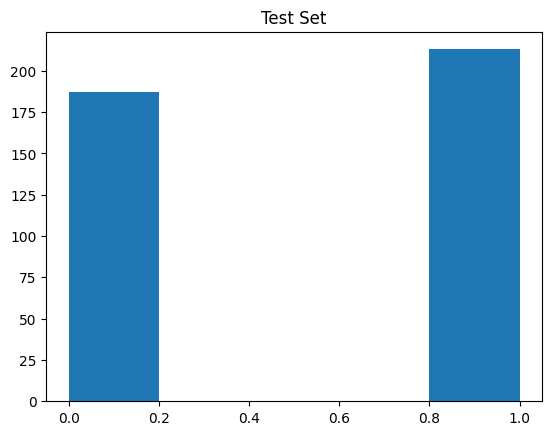

In [10]:
show_label_distribution(test_labels, 'Test Set')

# Hyperparameter Tuning

In [11]:
# import keras_tuner as kt
# from tensorflow import keras
# from tensorflow.keras import layers

# mirrored_strategy = tf.distribute.MirroredStrategy()

# with mirrored_strategy.scope():
#     def build_model(hp):
#         model = keras.Sequential()
        
#         # Data Augmentation with tunable parameters
#         model.add(layers.experimental.preprocessing.RandomFlip(
#             mode=hp.Choice('flip_mode', values=['horizontal', 'vertical', 'horizontal_and_vertical']),
#             input_shape=(224, 224, 3)))
#         model.add(layers.experimental.preprocessing.RandomRotation(
#             factor=hp.Float('rotation_factor', min_value=0.0, max_value=0.1))),
#         model.add(layers.experimental.preprocessing.RandomZoom(
#             height_factor=hp.Float('height_factor', min_value=-0.50, max_value=0.05),
#             width_factor=hp.Float('width_factor', min_value=-0.50, max_value=0.05)))
#         model.add(layers.experimental.preprocessing.RandomContrast(
#             factor=hp.Float('contrast_factor', min_value=0.005, max_value=0.3)))
    

        
#         # Base model without top layers
#         base_model = keras.applications.ResNet50V2(include_top=False, weights='imagenet', input_shape=(224, 224, 3))
#         base_model.trainable = False
#         model.add(base_model)
        
#         # Custom layers atop the pre-trained model
#         model.add(layers.GlobalAveragePooling2D())
#         model.add(layers.Dense(units=hp.Int('units_1', min_value=64, max_value=1024, step=32), activation='relu')),
#         model.add(layers.Dropout(rate=hp.Float('dropout_rate_1', min_value=0.0, max_value=0.5, step=0.1))),
#         model.add(layers.Dense(units=hp.Int('units_2', min_value=64, max_value=1024, step=32), activation='relu')),
#         model.add(layers.Dropout(rate=hp.Float('dropout_rate_2', min_value=0.0, max_value=0.5, step=0.1))),
#         # model.add(layers.Dense(units=hp.Int('units', min_value=64, max_value=1024, step=32), activation='relu')),
#         # model.add(layers.Dropout(rate=hp.Float('dropout_rate', min_value=0.0, max_value=0.5, step=0.1))),
#         model.add(layers.Dense(5, activation='softmax'))  # Adjust the number of units based on your number of classes
        
#         # Compile the model
#         model.compile(optimizer=keras.optimizers.Adam(
#             hp.Choice('learning_rate', values=[1e-3, 1e-4])),
#             loss='sparse_categorical_crossentropy',
#             metrics=['accuracy'])
        
#         return model

In [12]:
# # Initialize the tuner
# tuner = kt.Hyperband(build_model,
#                      objective='val_accuracy',
#                      distribution_strategy=mirrored_strategy,
#                      max_epochs=33,
#                      factor=3,
#                      directory='1_PALM_distributed_tuning',
#                      project_name='1_PALM_fine_tuning')

In [13]:
# # Start the search
# tuner.search(train_ds, epochs=33, validation_data=val_ds)  # Ensure train_ds and val_ds are defined and preprocessed

In [14]:
# # Get the optimal hyperparameters
# _1_best_hps_PALM = tuner.get_best_hyperparameters(num_trials=1)[0]

# # Build the model with the best hyperparameters
# _1_best_model_PALM = tuner.hypermodel.build(_1_best_hps_PALM)

In [15]:
# # Get the optimal hyperparameters
# _1_best_hps_PALM = tuner.get_best_hyperparameters(num_trials=1)[0]

# # Print out the best hyperparameters
# print("Best hyperparameters found by the _1_best_model_PALM_tuner:\n")
# for hp in _1_best_hps_PALM.values:
#     print(f"{hp}: {_1_best_hps_PALM.get(hp)}")

In [16]:
_1_best_hps_PALM = {
    'flip_mode': 'vertical',
'rotation_factor': 0.04490436032657651,
'height_factor': -0.1797158882949808,
'width_factor': -0.290893850350352,
'contrast_factor': 0.06613383902429272,
'units_1': 96,
'dropout_rate_1': 0.0,
'units_2': 448,
'dropout_rate_2': 0.4,
'learning_rate': 0.001,
'tuner/epochs': 11,
'tuner/initial_epoch': 0,
'tuner/bracket': 1,
'tuner/round': 0,
}

## Build the First Best Model Based on HyperParameters

In [17]:
from tensorflow.keras import layers
import tensorflow.keras as keras

def build_model():
    model = keras.Sequential()
    
    # Data Augmentation with tunable parameters
    model.add(layers.RandomFlip('vertical'))
    model.add(layers.RandomRotation(0.04490436032657651)),
    model.add(layers.RandomZoom(-0.1797158882949808, -0.290893850350352)),
    model.add(layers.RandomContrast(0.06613383902429272)),

    # Base model without top layers
    base_model = keras.applications.ResNet50V2(include_top=False, weights='imagenet', input_shape=(224, 224, 3))
    # make the last 5 layers trainable
    for layer in base_model.layers[:-5]:
        layer.trainable = False
    
    model.add(base_model)

    # Custom layers atop the pre-trained model
    model.add(layers.GlobalAveragePooling2D()),
    model.add(layers.Dense(96, activation='relu')),
    model.add(layers.Dropout(0.0)),
    model.add(layers.Dense(448, activation='relu')),
    model.add(layers.Dropout(0.4)),
    model.add(layers.Dense(2, activation='softmax'))

    # Compile the model
    model.compile(optimizer=keras.optimizers.Adam(0.001),
                          loss='sparse_categorical_crossentropy',
                          metrics=['accuracy'])
    # return the model
    return model

In [18]:
# Train the model with mirrored strategy
with mirrored_strategy.scope():
    _1_model = build_model()

In [19]:
# add history and early stopping 
early_stopping = keras.callbacks.EarlyStopping(
    monitor='val_accuracy',
    patience=25,
    restore_best_weights=True
)


In [20]:
# Train the model with early stopping with history
history = _1_model.fit(train_ds,
                 epochs=200,
                 validation_data=val_ds,
                 callbacks=[early_stopping]
                 )    

Epoch 1/200


2024-03-09 20:08:02.189823: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8907
2024-03-09 20:08:02.203904: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8907
2024-03-09 20:08:02.230007: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8907
2024-03-09 20:08:02.253462: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8907
2024-03-09 20:08:02.279294: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8907


 9/10 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 3.1836 - loss: 4.4560

2024-03-09 20:08:05.189041: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2024-03-09 20:08:05.189156: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
	 [[RemoteCall]]
2024-03-09 20:08:05.189540: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2024-03-09 20:08:05.189662: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
	 [[RemoteCall]]
2024-03-09 20:08:05.189728: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequen

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step - accuracy: 3.2533 - loss: 4.3001

2024-03-09 20:08:13.582936: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2024-03-09 20:08:13.583078: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
	 [[RemoteCall]]
2024-03-09 20:08:13.583144: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2024-03-09 20:08:13.583248: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
	 [[RemoteCall]]
2024-03-09 20:08:13.583294: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequen

10/10 ━━━━━━━━━━━━━━━━━━━━ 54s 1s/step - accuracy: 3.0257 - loss: 3.9693 - val_accuracy: 0.5417 - val_loss: 1.0468
Epoch 2/200
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 4.4967 - loss: 1.9136

2024-03-09 20:08:15.543824: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2024-03-09 20:08:15.543937: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
	 [[RemoteCall]]
2024-03-09 20:08:15.544447: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2024-03-09 20:08:15.544532: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2024-03-09 20:08:15.544627: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node Mul

10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 160ms/step - accuracy: 4.1661 - loss: 1.7777 - val_accuracy: 0.7292 - val_loss: 0.4093
Epoch 3/200


2024-03-09 20:08:16.251193: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2024-03-09 20:08:16.251296: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2024-03-09 20:08:16.251365: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
	 [[RemoteCall]]
2024-03-09 20:08:16.251427: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2024-03-09 20:08:16.251535: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node Mul

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - accuracy: 4.5575 - loss: 1.2993

2024-03-09 20:08:17.940464: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2024-03-09 20:08:17.940591: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
	 [[RemoteCall]]
2024-03-09 20:08:17.940886: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2024-03-09 20:08:17.941003: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
	 [[RemoteCall]]
2024-03-09 20:08:17.941111: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequen

10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 171ms/step - accuracy: 4.2256 - loss: 1.2029 - val_accuracy: 0.7500 - val_loss: 0.4496
Epoch 4/200
 9/10 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 4.5339 - loss: 1.5087

2024-03-09 20:08:20.225505: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2024-03-09 20:08:20.225613: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
	 [[RemoteCall]]
2024-03-09 20:08:20.226161: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2024-03-09 20:08:20.226307: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
	 [[RemoteCall]]
2024-03-09 20:08:20.226442: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequen

10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 160ms/step - accuracy: 4.2043 - loss: 1.3829 - val_accuracy: 0.7708 - val_loss: 0.4538
Epoch 5/200


2024-03-09 20:08:20.913596: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2024-03-09 20:08:20.913727: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
	 [[RemoteCall]]
2024-03-09 20:08:20.913783: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2024-03-09 20:08:20.913860: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
	 [[RemoteCall]]
2024-03-09 20:08:20.913931: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequen

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 4.5290 - loss: 1.5243

2024-03-09 20:08:22.285005: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2024-03-09 20:08:22.285150: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
	 [[RemoteCall]]
2024-03-09 20:08:22.285590: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2024-03-09 20:08:22.285712: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
	 [[RemoteCall]]
2024-03-09 20:08:22.285787: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequen

10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 214ms/step - accuracy: 4.2025 - loss: 1.4032 - val_accuracy: 0.7917 - val_loss: 0.4352
Epoch 6/200
 9/10 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 4.5776 - loss: 1.1692

2024-03-09 20:08:24.885667: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2024-03-09 20:08:24.885797: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
	 [[RemoteCall]]
2024-03-09 20:08:24.886157: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2024-03-09 20:08:24.886301: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
	 [[RemoteCall]]
2024-03-09 20:08:24.886608: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequen

10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 147ms/step - accuracy: 4.2482 - loss: 1.0913 - val_accuracy: 0.7917 - val_loss: 0.4494
Epoch 7/200


2024-03-09 20:08:25.611393: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2024-03-09 20:08:25.611497: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
	 [[RemoteCall]]
2024-03-09 20:08:25.611553: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2024-03-09 20:08:25.611653: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
	 [[RemoteCall]]
2024-03-09 20:08:25.611781: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequen

 9/10 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 4.6825 - loss: 0.9897

2024-03-09 20:08:26.868217: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2024-03-09 20:08:26.868342: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
	 [[RemoteCall]]
2024-03-09 20:08:26.868625: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2024-03-09 20:08:26.868744: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
	 [[RemoteCall]]
2024-03-09 20:08:26.868985: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequen

10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 144ms/step - accuracy: 4.3392 - loss: 0.9203 - val_accuracy: 0.6875 - val_loss: 0.5765
Epoch 8/200


2024-03-09 20:08:27.556414: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2024-03-09 20:08:27.556548: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
	 [[RemoteCall]]
2024-03-09 20:08:27.556731: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2024-03-09 20:08:27.556835: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2024-03-09 20:08:27.556898: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node Mul

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 4.5837 - loss: 1.0818

2024-03-09 20:08:28.880435: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2024-03-09 20:08:28.880596: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
	 [[RemoteCall]]
2024-03-09 20:08:28.881056: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2024-03-09 20:08:28.881168: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
	 [[RemoteCall]]
2024-03-09 20:08:28.881233: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequen

10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 222ms/step - accuracy: 4.2470 - loss: 1.0099 - val_accuracy: 0.8125 - val_loss: 0.3724
Epoch 9/200
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - accuracy: 4.6134 - loss: 1.0328

2024-03-09 20:08:31.475398: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2024-03-09 20:08:31.475477: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2024-03-09 20:08:31.475533: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
	 [[RemoteCall]]
2024-03-09 20:08:31.475599: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
	 [[RemoteCall]]
2024-03-09 20:08:31.475647: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequen

10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 143ms/step - accuracy: 4.2787 - loss: 0.9556 - val_accuracy: 0.6667 - val_loss: 0.7668
Epoch 10/200


2024-03-09 20:08:32.188373: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2024-03-09 20:08:32.188455: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2024-03-09 20:08:32.188537: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2024-03-09 20:08:32.188586: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2024-03-09 20:08:32.188655: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorG

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 4.6839 - loss: 1.0194

2024-03-09 20:08:33.465876: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2024-03-09 20:08:33.466011: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
	 [[RemoteCall]]
2024-03-09 20:08:33.466340: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2024-03-09 20:08:33.466448: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
	 [[RemoteCall]]
2024-03-09 20:08:33.466617: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequen

10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 148ms/step - accuracy: 4.3438 - loss: 0.9455 - val_accuracy: 0.7500 - val_loss: 0.4284
Epoch 11/200


2024-03-09 20:08:34.182885: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2024-03-09 20:08:34.182981: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2024-03-09 20:08:34.183076: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2024-03-09 20:08:34.183155: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
	 [[RemoteCall]]
2024-03-09 20:08:34.183233: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node Mul

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 4.6535 - loss: 1.0481

2024-03-09 20:08:35.818808: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2024-03-09 20:08:35.818944: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
	 [[RemoteCall]]
2024-03-09 20:08:35.819297: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2024-03-09 20:08:35.819399: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2024-03-09 20:08:35.819478: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node Mul

10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 141ms/step - accuracy: 4.3171 - loss: 0.9687 - val_accuracy: 0.5417 - val_loss: 1.0367
Epoch 12/200


2024-03-09 20:08:36.488897: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2024-03-09 20:08:36.489011: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
	 [[RemoteCall]]
2024-03-09 20:08:36.489073: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2024-03-09 20:08:36.489151: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
	 [[RemoteCall]]
2024-03-09 20:08:36.489244: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequen

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 4.7203 - loss: 0.8149

2024-03-09 20:08:37.734487: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2024-03-09 20:08:37.734628: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
	 [[RemoteCall]]
2024-03-09 20:08:37.734945: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2024-03-09 20:08:37.735051: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
	 [[RemoteCall]]
2024-03-09 20:08:37.735357: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequen

10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 144ms/step - accuracy: 4.3736 - loss: 0.7653 - val_accuracy: 0.6458 - val_loss: 0.5767
Epoch 13/200


2024-03-09 20:08:38.426723: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2024-03-09 20:08:38.426862: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
	 [[RemoteCall]]
2024-03-09 20:08:38.426910: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2024-03-09 20:08:38.426998: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2024-03-09 20:08:38.427072: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node Mul

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 4.7568 - loss: 0.8030

2024-03-09 20:08:39.711176: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2024-03-09 20:08:39.711297: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
	 [[RemoteCall]]
2024-03-09 20:08:39.711373: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2024-03-09 20:08:39.711493: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
	 [[RemoteCall]]
2024-03-09 20:08:39.712120: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequen

10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 166ms/step - accuracy: 4.4091 - loss: 0.7480 - val_accuracy: 0.8750 - val_loss: 0.2307
Epoch 14/200
 9/10 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 4.6776 - loss: 0.9942

2024-03-09 20:08:42.397219: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2024-03-09 20:08:42.397308: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2024-03-09 20:08:42.397379: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
	 [[RemoteCall]]
2024-03-09 20:08:42.397427: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2024-03-09 20:08:42.397521: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node Mul

10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 146ms/step - accuracy: 4.3413 - loss: 0.9065 - val_accuracy: 0.8542 - val_loss: 0.2597
Epoch 15/200


2024-03-09 20:08:43.098482: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2024-03-09 20:08:43.098587: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2024-03-09 20:08:43.098671: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
	 [[RemoteCall]]
2024-03-09 20:08:43.098741: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2024-03-09 20:08:43.098816: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node Mul

 9/10 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 4.6055 - loss: 0.9020

2024-03-09 20:08:44.885909: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2024-03-09 20:08:44.886035: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
	 [[RemoteCall]]
2024-03-09 20:08:44.886112: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2024-03-09 20:08:44.886216: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2024-03-09 20:08:44.886316: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node Mul

10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 196ms/step - accuracy: 4.2743 - loss: 0.8361 - val_accuracy: 0.8542 - val_loss: 0.2789
Epoch 16/200
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 4.6525 - loss: 0.9673

2024-03-09 20:08:47.364477: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2024-03-09 20:08:47.364605: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
	 [[RemoteCall]]
2024-03-09 20:08:47.364676: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2024-03-09 20:08:47.364788: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
	 [[RemoteCall]]
2024-03-09 20:08:47.364833: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequen

10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 149ms/step - accuracy: 4.3138 - loss: 0.8986 - val_accuracy: 0.7917 - val_loss: 0.7712
Epoch 17/200


2024-03-09 20:08:48.114164: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2024-03-09 20:08:48.114233: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
	 [[RemoteCall]]
2024-03-09 20:08:48.114290: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2024-03-09 20:08:48.114382: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2024-03-09 20:08:48.114472: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node Mul

 9/10 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 4.6594 - loss: 0.7972

2024-03-09 20:08:49.435275: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2024-03-09 20:08:49.435400: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
	 [[RemoteCall]]
2024-03-09 20:08:49.436027: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2024-03-09 20:08:49.436146: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
	 [[RemoteCall]]
2024-03-09 20:08:49.436350: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequen

10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 142ms/step - accuracy: 4.3179 - loss: 0.7478 - val_accuracy: 0.7708 - val_loss: 0.7025
Epoch 18/200


2024-03-09 20:08:50.125008: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2024-03-09 20:08:50.125132: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
	 [[RemoteCall]]
2024-03-09 20:08:50.125203: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2024-03-09 20:08:50.125340: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
	 [[RemoteCall]]
2024-03-09 20:08:50.125382: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequen

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 4.7158 - loss: 0.9955

2024-03-09 20:08:51.467896: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2024-03-09 20:08:51.468032: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
	 [[RemoteCall]]
2024-03-09 20:08:51.468430: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2024-03-09 20:08:51.468540: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
	 [[RemoteCall]]
2024-03-09 20:08:51.468737: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequen

10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 200ms/step - accuracy: 4.3728 - loss: 0.9210 - val_accuracy: 0.8125 - val_loss: 0.4180
Epoch 19/200


2024-03-09 20:08:52.664191: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2024-03-09 20:08:52.664290: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2024-03-09 20:08:52.664384: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2024-03-09 20:08:52.664456: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2024-03-09 20:08:52.664523: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorG

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 4.7188 - loss: 0.7874

2024-03-09 20:08:53.961218: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2024-03-09 20:08:53.961360: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
	 [[RemoteCall]]
2024-03-09 20:08:53.961755: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2024-03-09 20:08:53.961862: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
	 [[RemoteCall]]
2024-03-09 20:08:53.961943: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequen

10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 154ms/step - accuracy: 4.3755 - loss: 0.7277 - val_accuracy: 0.7917 - val_loss: 0.5867
Epoch 20/200


2024-03-09 20:08:54.721408: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2024-03-09 20:08:54.721525: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2024-03-09 20:08:54.721593: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2024-03-09 20:08:54.721665: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
	 [[RemoteCall]]
2024-03-09 20:08:54.721744: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node Mul

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - accuracy: 4.7287 - loss: 0.7023

2024-03-09 20:08:56.082811: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2024-03-09 20:08:56.082921: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
	 [[RemoteCall]]
2024-03-09 20:08:56.082975: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2024-03-09 20:08:56.083090: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
	 [[RemoteCall]]
2024-03-09 20:08:56.083426: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequen

10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 146ms/step - accuracy: 4.3869 - loss: 0.6526 - val_accuracy: 0.7917 - val_loss: 0.6754
Epoch 21/200


2024-03-09 20:08:56.799895: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2024-03-09 20:08:56.800024: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
	 [[RemoteCall]]
2024-03-09 20:08:56.800185: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2024-03-09 20:08:56.800309: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
	 [[RemoteCall]]
2024-03-09 20:08:56.800382: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequen

 9/10 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 4.7177 - loss: 0.8038

2024-03-09 20:08:58.583519: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2024-03-09 20:08:58.583646: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
	 [[RemoteCall]]
2024-03-09 20:08:58.583696: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2024-03-09 20:08:58.583806: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
	 [[RemoteCall]]
2024-03-09 20:08:58.584322: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequen

10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 153ms/step - accuracy: 4.3746 - loss: 0.7408 - val_accuracy: 0.7708 - val_loss: 0.7552
Epoch 22/200


2024-03-09 20:08:59.350914: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2024-03-09 20:08:59.351021: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2024-03-09 20:08:59.351119: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
	 [[RemoteCall]]
2024-03-09 20:08:59.351190: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2024-03-09 20:08:59.351260: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node Mul

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 4.6699 - loss: 0.7732

2024-03-09 20:09:00.658246: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2024-03-09 20:09:00.658397: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
	 [[RemoteCall]]
2024-03-09 20:09:00.658813: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2024-03-09 20:09:00.658944: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
	 [[RemoteCall]]
2024-03-09 20:09:00.659278: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequen

10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 143ms/step - accuracy: 4.3301 - loss: 0.7172 - val_accuracy: 0.7292 - val_loss: 1.0707
Epoch 23/200


2024-03-09 20:09:01.346582: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2024-03-09 20:09:01.346665: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2024-03-09 20:09:01.346767: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2024-03-09 20:09:01.346855: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
	 [[RemoteCall]]
2024-03-09 20:09:01.346925: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node Mul

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 4.7907 - loss: 0.6121

2024-03-09 20:09:02.673456: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2024-03-09 20:09:02.673584: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
	 [[RemoteCall]]
2024-03-09 20:09:02.674109: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2024-03-09 20:09:02.674231: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2024-03-09 20:09:02.674307: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node Mul

10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 143ms/step - accuracy: 4.4385 - loss: 0.5742 - val_accuracy: 0.8125 - val_loss: 0.5131
Epoch 24/200


2024-03-09 20:09:03.382739: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2024-03-09 20:09:03.382914: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
	 [[RemoteCall]]
2024-03-09 20:09:03.383150: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2024-03-09 20:09:03.383244: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2024-03-09 20:09:03.383338: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node Mul

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 4.6736 - loss: 0.7214

2024-03-09 20:09:05.228916: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2024-03-09 20:09:05.229003: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
	 [[RemoteCall]]
2024-03-09 20:09:05.229330: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2024-03-09 20:09:05.229440: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
	 [[RemoteCall]]
2024-03-09 20:09:05.229539: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequen

10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 156ms/step - accuracy: 4.3382 - loss: 0.6606 - val_accuracy: 0.8333 - val_loss: 0.6921
Epoch 25/200


2024-03-09 20:09:05.967544: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2024-03-09 20:09:05.967608: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2024-03-09 20:09:05.967662: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2024-03-09 20:09:05.967743: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2024-03-09 20:09:05.967804: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorG

 9/10 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 4.7553 - loss: 0.6876

2024-03-09 20:09:07.340357: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2024-03-09 20:09:07.340489: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
	 [[RemoteCall]]
2024-03-09 20:09:07.340775: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2024-03-09 20:09:07.340906: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
	 [[RemoteCall]]
2024-03-09 20:09:07.341359: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequen

10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 161ms/step - accuracy: 4.4054 - loss: 0.6442 - val_accuracy: 0.7292 - val_loss: 1.0815
Epoch 26/200


2024-03-09 20:09:08.214872: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2024-03-09 20:09:08.214954: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2024-03-09 20:09:08.215041: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2024-03-09 20:09:08.215127: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
	 [[RemoteCall]]
2024-03-09 20:09:08.215157: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node Mul

 9/10 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 4.7774 - loss: 0.6305

2024-03-09 20:09:09.523322: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2024-03-09 20:09:09.523435: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2024-03-09 20:09:09.523556: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
	 [[RemoteCall]]
2024-03-09 20:09:09.523631: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
	 [[RemoteCall]]
2024-03-09 20:09:09.523939: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequen

10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 197ms/step - accuracy: 4.4296 - loss: 0.5905 - val_accuracy: 0.8125 - val_loss: 0.5900
Epoch 27/200


2024-03-09 20:09:10.675121: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2024-03-09 20:09:10.675265: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
	 [[RemoteCall]]
2024-03-09 20:09:10.675333: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2024-03-09 20:09:10.675410: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2024-03-09 20:09:10.675494: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node Mul

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 4.7642 - loss: 0.6149

2024-03-09 20:09:12.001905: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2024-03-09 20:09:12.002034: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
	 [[RemoteCall]]
2024-03-09 20:09:12.002420: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2024-03-09 20:09:12.002509: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
	 [[RemoteCall]]
2024-03-09 20:09:12.002601: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequen

10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 153ms/step - accuracy: 4.4172 - loss: 0.5730 - val_accuracy: 0.8333 - val_loss: 0.4021
Epoch 28/200


2024-03-09 20:09:12.770487: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2024-03-09 20:09:12.770560: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2024-03-09 20:09:12.770627: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
	 [[RemoteCall]]
2024-03-09 20:09:12.770692: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
	 [[RemoteCall]]
2024-03-09 20:09:12.770766: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequen

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 4.7610 - loss: 0.6927

2024-03-09 20:09:14.162827: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2024-03-09 20:09:14.162966: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
	 [[RemoteCall]]
2024-03-09 20:09:14.163293: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2024-03-09 20:09:14.163369: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
	 [[RemoteCall]]
2024-03-09 20:09:14.163452: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequen

10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 150ms/step - accuracy: 4.4162 - loss: 0.6385 - val_accuracy: 0.7917 - val_loss: 0.3737
Epoch 29/200


2024-03-09 20:09:14.863975: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2024-03-09 20:09:14.864093: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2024-03-09 20:09:14.864424: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
	 [[RemoteCall]]
2024-03-09 20:09:14.864503: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2024-03-09 20:09:14.864573: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node Mul

 9/10 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 4.6434 - loss: 0.8857

2024-03-09 20:09:16.130841: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2024-03-09 20:09:16.130947: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2024-03-09 20:09:16.131043: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
	 [[RemoteCall]]
2024-03-09 20:09:16.131101: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
	 [[RemoteCall]]
2024-03-09 20:09:16.131429: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequen

10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 195ms/step - accuracy: 4.3128 - loss: 0.8060 - val_accuracy: 0.8125 - val_loss: 0.4611
Epoch 30/200


2024-03-09 20:09:17.274689: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2024-03-09 20:09:17.274783: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2024-03-09 20:09:17.274869: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2024-03-09 20:09:17.274935: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2024-03-09 20:09:17.275019: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorG

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 4.7393 - loss: 0.6765

2024-03-09 20:09:18.604514: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2024-03-09 20:09:18.604638: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
	 [[RemoteCall]]
2024-03-09 20:09:18.605195: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2024-03-09 20:09:18.605275: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
	 [[RemoteCall]]
2024-03-09 20:09:18.605681: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequen

10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 152ms/step - accuracy: 4.3956 - loss: 0.6259 - val_accuracy: 0.8125 - val_loss: 0.5016
Epoch 31/200


2024-03-09 20:09:19.328021: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2024-03-09 20:09:19.328101: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2024-03-09 20:09:19.328173: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
	 [[RemoteCall]]
2024-03-09 20:09:19.328231: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
	 [[RemoteCall]]
2024-03-09 20:09:19.328343: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequen

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 4.6862 - loss: 0.8894

2024-03-09 20:09:20.614768: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2024-03-09 20:09:20.614915: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
	 [[RemoteCall]]
2024-03-09 20:09:20.615241: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2024-03-09 20:09:20.615294: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2024-03-09 20:09:20.615380: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node Mul

10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 146ms/step - accuracy: 4.3450 - loss: 0.8215 - val_accuracy: 0.7708 - val_loss: 0.8245
Epoch 32/200


2024-03-09 20:09:21.329529: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2024-03-09 20:09:21.329667: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2024-03-09 20:09:21.329754: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
	 [[RemoteCall]]
2024-03-09 20:09:21.329830: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2024-03-09 20:09:21.329918: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node Mul

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - accuracy: 4.7636 - loss: 0.6983

2024-03-09 20:09:23.067786: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2024-03-09 20:09:23.067935: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
	 [[RemoteCall]]
2024-03-09 20:09:23.068098: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2024-03-09 20:09:23.068253: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
	 [[RemoteCall]]
2024-03-09 20:09:23.068491: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequen

10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 151ms/step - accuracy: 4.4191 - loss: 0.6433 - val_accuracy: 0.7917 - val_loss: 1.0315
Epoch 33/200


2024-03-09 20:09:23.781706: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2024-03-09 20:09:23.781785: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2024-03-09 20:09:23.781847: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2024-03-09 20:09:23.781948: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
	 [[RemoteCall]]
2024-03-09 20:09:23.781993: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node Mul

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - accuracy: 4.7520 - loss: 0.6532

2024-03-09 20:09:25.004373: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2024-03-09 20:09:25.004484: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
	 [[RemoteCall]]
2024-03-09 20:09:25.004708: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2024-03-09 20:09:25.004814: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
	 [[RemoteCall]]
2024-03-09 20:09:25.004983: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequen

10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 138ms/step - accuracy: 4.4076 - loss: 0.5990 - val_accuracy: 0.6250 - val_loss: 2.1183
Epoch 34/200


2024-03-09 20:09:25.670009: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2024-03-09 20:09:25.670079: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2024-03-09 20:09:25.670178: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
	 [[RemoteCall]]
2024-03-09 20:09:25.670242: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2024-03-09 20:09:25.670314: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node Mul

 9/10 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 4.7734 - loss: 0.7169

2024-03-09 20:09:27.045880: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2024-03-09 20:09:27.046012: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
	 [[RemoteCall]]
2024-03-09 20:09:27.046344: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2024-03-09 20:09:27.046440: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2024-03-09 20:09:27.046512: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node Mul

10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 209ms/step - accuracy: 4.4273 - loss: 0.6614 - val_accuracy: 0.7500 - val_loss: 1.3579
Epoch 35/200


2024-03-09 20:09:28.278405: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2024-03-09 20:09:28.278475: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2024-03-09 20:09:28.278535: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2024-03-09 20:09:28.278611: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
	 [[RemoteCall]]
2024-03-09 20:09:28.278652: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node Mul

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 4.7743 - loss: 0.6363

2024-03-09 20:09:29.540112: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2024-03-09 20:09:29.540267: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
	 [[RemoteCall]]
2024-03-09 20:09:29.540749: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2024-03-09 20:09:29.540835: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
	 [[RemoteCall]]
2024-03-09 20:09:29.540905: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequen

10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 147ms/step - accuracy: 4.4283 - loss: 0.5882 - val_accuracy: 0.7917 - val_loss: 0.8587
Epoch 36/200


2024-03-09 20:09:30.269370: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2024-03-09 20:09:30.269478: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2024-03-09 20:09:30.269564: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
	 [[RemoteCall]]
2024-03-09 20:09:30.269636: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
	 [[RemoteCall]]
2024-03-09 20:09:30.269692: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequen

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 4.7151 - loss: 0.7953

2024-03-09 20:09:31.581653: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2024-03-09 20:09:31.581754: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
	 [[RemoteCall]]
2024-03-09 20:09:31.582059: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2024-03-09 20:09:31.582160: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
	 [[RemoteCall]]
2024-03-09 20:09:31.582403: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequen

10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 147ms/step - accuracy: 4.3745 - loss: 0.7316 - val_accuracy: 0.7500 - val_loss: 1.0873
Epoch 37/200


2024-03-09 20:09:32.293999: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2024-03-09 20:09:32.294127: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2024-03-09 20:09:32.294204: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
	 [[RemoteCall]]
2024-03-09 20:09:32.294282: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
	 [[RemoteCall]]
2024-03-09 20:09:32.294509: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequen

 9/10 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - accuracy: 4.6619 - loss: 0.8490

2024-03-09 20:09:33.608828: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2024-03-09 20:09:33.608962: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
	 [[RemoteCall]]
2024-03-09 20:09:33.609204: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2024-03-09 20:09:33.609285: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2024-03-09 20:09:33.609372: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node Mul

10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 200ms/step - accuracy: 4.3304 - loss: 0.7682 - val_accuracy: 0.6458 - val_loss: 1.8226
Epoch 38/200


2024-03-09 20:09:34.787800: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2024-03-09 20:09:34.787879: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
	 [[RemoteCall]]
2024-03-09 20:09:34.787955: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2024-03-09 20:09:34.788043: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
	 [[RemoteCall]]
2024-03-09 20:09:34.788104: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequen

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 4.7965 - loss: 0.6058

2024-03-09 20:09:36.095303: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2024-03-09 20:09:36.095421: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
	 [[RemoteCall]]
2024-03-09 20:09:36.095735: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2024-03-09 20:09:36.095889: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
	 [[RemoteCall]]
2024-03-09 20:09:36.096227: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequen

10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 148ms/step - accuracy: 4.4481 - loss: 0.5575 - val_accuracy: 0.7500 - val_loss: 1.2345


2024-03-09 20:09:36.807483: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2024-03-09 20:09:36.807593: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
	 [[RemoteCall]]
2024-03-09 20:09:36.807654: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2024-03-09 20:09:36.807741: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
	 [[RemoteCall]]
2024-03-09 20:09:36.807839: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequen

In [21]:
from datetime import datetime

# `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')

from datetime import datetime

# Get the current date and time formatted as a string
timestamp = datetime.now().strftime('%Y-%m-%d_%H-%M-%S')

# Construct the file path with the timestamp for saving the model
model_filename = f'/home/nate/distributed_training/PALM-Distributed-Training/Saved_models/_1_model_{timestamp}.keras'

_1_model.save(model_filename)


<Axes: >

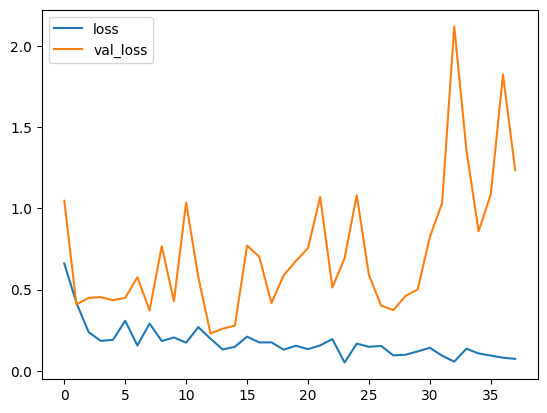

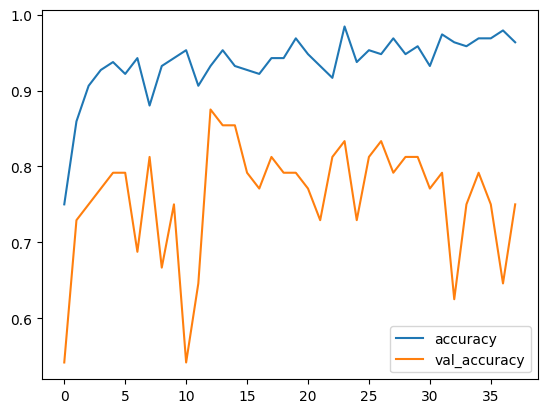

In [22]:
# print out the training history
history_frame = pd.DataFrame(history.history)
history_frame.loc[:, ['loss', 'val_loss']].plot()
history_frame.loc[:, ['accuracy', 'val_accuracy']].plot()

NameError: name 'true_classes' is not defined

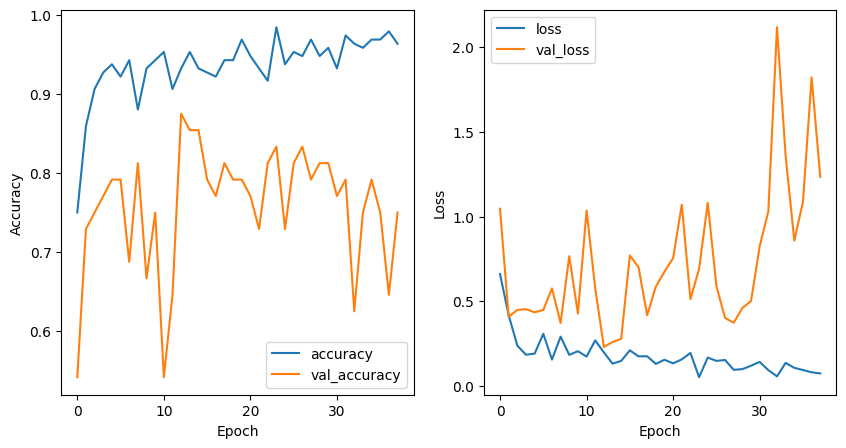

In [25]:
# show progress in training
def plot_progress(history):
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='accuracy')
    plt.plot(history.history['val_accuracy'], label='val_accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

plot_progress(history)

In [26]:
# test the model with distributed strategy
test_dataset = create_dataset(list(test_image_paths), list(test_labels), BATCH_SIZE, is_training=False)
_1_model.evaluate(test_dataset)

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 95ms/step - accuracy: 3.7150 - loss: 1.1397


2024-03-09 20:10:49.768088: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2024-03-09 20:10:49.768169: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
	 [[RemoteCall]]
2024-03-09 20:10:49.768370: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2024-03-09 20:10:49.768434: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
	 [[RemoteCall]]
2024-03-09 20:10:49.768490: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequen

[0.30548229813575745, 0.875]